In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import sys
sys.path.append('/Users/sbecker/Projects/RL_reward_novelty/') 

import src.models.snov.gabor_stimuli as gs
import src.models.snov.run_gabor_knov2 as gknov2

import src.utils.saveload as sl
import src.utils.visualization as vis
import src.scripts.sum_of_parts.test_parent_child_sim as tpcs
import src.scripts.sum_of_parts.plot_similarity_modulation_homann as smh
import src.scripts.sum_of_parts.exp_pred_helpers as eph

In [21]:
plt.style.use('/Users/sbecker/Projects/RL_reward_novelty/src/scripts/Figures_Paper/paper.mplstyle')

# Check rotation-to-similarity mapping

In [ ]:
rotate = np.linspace(0*np.pi,np.pi,20)

k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=1,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant_fixed',fixed_freq=0.06,contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=False)

parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0,gabor_num=(6,2),fixed_freq=0.06,rng=np.random.default_rng(seed_parent))
parent[0,:] = 0
im_parent, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],parent,resolution=100,magn=1,add_eps=0)

child1 = parent[:,0].copy()
im_child1, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],child1.reshape((-1,1)),resolution=100,magn=1,add_eps=0)

sim_all = []; sim_pixel_all = []
for i in range(len(rotate)):
    
    child2 = parent.copy()
    child2[0,:] += rotate[i]
    im_child2, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],child2,resolution=100,magn=1,add_eps=0)
    im_children = [im_child1, im_child2]

    pairwise_sim_pixel = eph.comp_pairwise_sim(im_children)
    sim_pixel_all.append(pairwise_sim_pixel[0,1])
    
    vec_children = np.stack(im_children)
    kmat_children = eph.compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
    kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]

    pairwise_sim = eph.comp_pairwise_sim(kernels_children)
    sim_all.append(pairwise_sim[0,1])

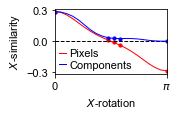

In [100]:
# Set paths
folder_name = '2024-11_exp-pred1_sum-of-parts'
path_data = path_data = f'/Users/sbecker/Projects/RL_reward_novelty/data/{folder_name}/'
path_fig = f'/Users/sbecker/Projects/RL_reward_novelty/output/{folder_name}/'

seed_parent = 12345
name_data   = f'm_exp_seed-{seed_parent}_12base'
name_fig    = name_data 

save_path = path_fig
save_name = name_fig

rotate = np.linspace(0*np.pi,np.pi,20)
plot_rot = np.array([0, 0.5, 0.509, 0.6, 1])*np.pi
idx_rot = []
for i in range(len(plot_rot)):
    rot_diff = np.abs(rotate-plot_rot[i])
    i_rot = np.where(rot_diff==np.min(rot_diff))[0][0]  
    idx_rot.append(i_rot)

f, ax = plt.subplots(1,1,figsize=(2,1.2))
ax.axhline(0,linestyle='--',color='k')
ax.plot(rotate,sim_pixel_all,'r',label='Pixels')
ax.plot(rotate,sim_all,'b',label='Components')
ax.scatter(rotate[idx_rot],np.array(sim_pixel_all)[idx_rot],c='r',s=10)
ax.scatter(rotate[idx_rot],np.array(sim_all)[idx_rot],c='b',s=10)
ax.set_xlabel('$X$-rotation')
ax.set_ylabel('$X$-similarity')
ax.set_xticks([0,np.pi])
ax.set_xticklabels(['0','$\pi$'])
ax.set_xlim([0,np.pi])
ax.set_yticks([-0.3,0,0.3])
ax.legend(loc='lower left',frameon=False,handlelength=0.6,handletextpad=0.3,bbox_to_anchor=(-0.05,-0.09),labelspacing=0.1)
# f.tight_layout()
f.savefig(os.path.join(save_path,f'{save_name}_rot2sim.svg'))
f.savefig(os.path.join(save_path,f'{save_name}_rot2sim.png'))  

# Functions

In [77]:
def plot_pairwise_sim_matrix(pairwise_sim,f,ax):
    # minsim = np.min(pairwise_sim.flatten())
    # maxsim = np.max(pairwise_sim.flatten())
    plot_sim = np.zeros((4,4))
    plot_sim[:3,:3] = pairwise_sim[:3,:3] # add top left 3x3
    plot_sim[3,:3] = pairwise_sim[-1,:3] # add last row
    plot_sim[:3,3] = pairwise_sim[:3,-1] # add last column
    plot_sim[3,3] = pairwise_sim[-1,-1] # add bottom right
    asim = ax.imshow(plot_sim,cmap='Blues',vmin=0,vmax=1) #,norm=colors.CenteredNorm(vcenter=np.mean(pairwise_sim.flatten()))) 
    # for i in range(pairwise_sim.shape[0]):
        # for j in range(pairwise_sim.shape[1]):
            # ax.text(j, i, np.round(pairwise_sim[i, j],2), ha="center", va="center", color="k")
    # ax.set_title(title)
    xt = np.arange(plot_sim.shape[0])
    xtl = ['$I_{' + f'{ii+1}' + '}$' for ii in xt[:-1]] + ['X']
    ax.set_xticks(xt)
    ax.set_xticklabels(xtl,fontsize=11)
    ax.set_yticks(xt)
    ax.set_yticklabels(xtl,fontsize=11)
    f.colorbar(asim, ax=ax,shrink=0.8,label='Similarity')

In [75]:
def plot_protocol(rotate,unit_orient=0,plot_stim=True,seed_parent=12345,save_path='',save_name='',exp_type='m',random_image=False):
    # Set parameters according to experiment type
    if exp_type=='l': 
        num_child = 3
        plot_exp = [True,False,False]
        idx_exp = 0
        fun_plot_seq = eph.plot_sequence_l
    elif exp_type=='m': 
        num_child = 12
        plot_exp = [False,True,False]
        idx_exp = 1
        fun_plot_seq = eph.plot_sequence_m
    elif exp_type=='lp': 
        num_child = 3
        plot_exp = [False,False,True]
        idx_exp = 2
        fun_plot_seq = eph.plot_sequence_lp

    # Make kernel model
    k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=1,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant_fixed',fixed_freq=0.06,contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=False)

    # Generate parent image
    if random_image:
        parent = gs.generate_stim(gs.dim_ranges_rad,6*2,np.random.default_rng(seed_parent),sampling='basic',fixed_freq=0.06)
    else:
        parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0,gabor_num=(6,2),fixed_freq=0.06,rng=np.random.default_rng(seed_parent))
        parent[0,:] = unit_orient

    # Generate shuffles of parent
    sim_data_raw = []; sim_stats_raw = []; sim_oddsim = []; sim_oddsim_vec = []; sim_rotate = []; sim_perm_id = []
    parent_perm = parent

    # Generate familiar sequence (constant children)
    if exp_type=='lp' or exp_type=='l':
        num_gpc =  np.floor(parent_perm.shape[1]/num_child).astype(int)
        children = [parent_perm[:,i*num_gpc:(i+1)*num_gpc] for i in range(num_child)]
        df_children = [pd.DataFrame(dict(zip(gs.dim_names,children[i]))) for i in range(len(children))] 

        im_children = []
        for j in range(len(children)):
            im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[j],resolution=100,magn=1,add_eps=0)
            im_children.append(im_child)

    else:
        children = [parent_perm[:,i] for i in range(num_child)]
        df_children = [pd.DataFrame(dict(zip(gs.dim_names,children[i])),index=[0]) for i in range(len(children))]

        im_children = []
        for j in range(len(children)):
            im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[j].reshape((-1,1)),resolution=100,magn=1,add_eps=0)
            im_children.append(im_child)  

    for i_rot in range(len(rotate)):
        if exp_type=='lp':
            # Generate similar replacement sequence
            df_children_i = df_children.copy()
            im_children_i = im_children.copy()

            for j in range(num_child):
                last_child = children[j].copy()
                last_child[0] += rotate[i_rot]
                df_children_i.append(pd.DataFrame(dict(zip(gs.dim_names,last_child))))
                im_last_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],last_child,resolution=100,magn=1)
                im_children_i.append(im_last_child)

            all_children_i = [(df_children_i,im_children_i)]

        else:
            # Generate similar novel image
            df_children_i = df_children.copy()
            im_children_i = im_children.copy() 

            last_child = parent.copy() 
            last_child[0,:] += rotate[i_rot]
            df_children_i.append(pd.DataFrame(dict(zip(gs.dim_names,last_child))))
            im_last_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],last_child,resolution=100,magn=1)
            im_children_i.append(im_last_child)

            all_children_i = [(df_children_i,im_children_i)]

        # Compute + plot similarity matrix of sequence
        vec_children = np.stack(im_children_i)
        kmat_children = eph.compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
        kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]

        pairwise_sim = eph.comp_pairwise_sim(kernels_children)
        pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
        sim_oddsim_vec.append(pairwise_sim[:-1,-1])
        sim_oddsim.append(np.mean(pairwise_sim[:-1,-1]))

        if plot_stim:
            f,ax = plt.subplots(1,1,figsize=(1.6,1.6))
            plot_pairwise_sim_matrix(pairwise_sim,f,ax)
            save_name_i = save_name+'_rot_'+str(i_rot)+'_simmat_m3'
            f.savefig(os.path.join(save_path,f'{save_name_i}.svg'))
        
        all_inputs_i = tpcs.generate_inputs_from_stimuli(all_children_i,sequence_mode='seq',plot_exp=plot_exp)

        if plot_stim:
            fax = fun_plot_seq(rotate[i_rot],all_inputs_i)
            if exp_type=='l' or exp_type=='lp':
                save_name_i = save_name+'_rot_'+str(i_rot)+'_protocol'
                fax[0].savefig(os.path.join(save_path,f'{save_name_i}.svg'))
            else:
                f = fax[0]
                for j in range(len(f)):
                    save_name_i = save_name+'_rot_'+str(i_rot)+f'_protocol-{j}'
                    f[j].savefig(os.path.join(save_path,f'{save_name_i}.svg'))

    return sim_data_raw, sim_stats_raw, sim_rotate, sim_perm_id, sim_oddsim, sim_oddsim_vec


In [13]:
def run_perm(rotate,unit_orient=0,plot_stim=False,permute_all=True,num_perm=20,seed_parent=12345,save_stats=True,save_path='',save_name='',exp_type='m',random_image=False):
    # Set parameters according to experiment type
    if exp_type=='l': 
        num_child = 3
        plot_exp = [True,False,False]
        idx_exp = 0
        fun_plot_seq = eph.plot_sequence_l
    elif exp_type=='m': 
        num_child = 12
        plot_exp = [False,True,False]
        idx_exp = 1
        fun_plot_seq = eph.plot_sequence_m
    elif exp_type=='lp': 
        num_child = 3
        plot_exp = [False,False,True]
        idx_exp = 2
        fun_plot_seq = eph.plot_sequence_lp

    # Make kernel model
    k_params = gknov2.init_gabor_knov(gnum=4,k_type='triangle',ksig=1,kcenter=1,cdens=1,seed=12345,rng=None,mask=True,conv=True,parallel=False,adj_w=True,adj_f=False,alph_adj=3,sampling='equidistant_fixed',fixed_freq=0.06,contrast='off',softmax_norm=False,eps_k=1,alph_k=0.1,add_empty=False,debug=False)

    # Generate parent image
    if random_image:
        parent = gs.generate_stim(gs.dim_ranges_rad,6*2,np.random.default_rng(seed_parent),sampling='basic',fixed_freq=0.06)
    else:
        parent, _ = gs.generate_teststim_parent(gs.dim_ranges_rad,init_orient=0,gabor_num=(6,2),fixed_freq=0.06,rng=np.random.default_rng(seed_parent))
        parent[0,:] = unit_orient

    # Generate shuffles of parent
    sim_data_raw = []; sim_stats_raw = []; sim_oddsim = []; sim_oddsim_vec = []; sim_rotate = []; sim_perm_id = []
    all_perm = []
    if permute_all:
        num_gabor = np.arange(parent.shape[1])
        for i_perm in range(num_perm):
            perm = np.random.permutation(num_gabor)
            all_perm.append(perm)
    else:
        all_perm.append(np.arange(parent.shape[1]))
        num_perm = 1

    for i_perm in range(len(all_perm)):
        perm = all_perm[i_perm]
        parent_perm = parent[:,perm]
        
        # Generate familiar sequence (constant children)
        if exp_type=='lp' or exp_type=='l':
            num_gpc =  np.floor(parent_perm.shape[1]/num_child).astype(int)
            children = [parent_perm[:,i*num_gpc:(i+1)*num_gpc] for i in range(num_child)]
            df_children = [pd.DataFrame(dict(zip(gs.dim_names,children[i]))) for i in range(len(children))] 

            im_children = []
            for j in range(len(children)):
                im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[j],resolution=100,magn=1,add_eps=0)
                im_children.append(im_child)

        else:
            children = [parent_perm[:,i] for i in range(num_child)]
            df_children = [pd.DataFrame(dict(zip(gs.dim_names,children[i])),index=[0]) for i in range(len(children))]

            im_children = []
            for j in range(len(children)):
                im_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],children[j].reshape((-1,1)),resolution=100,magn=1,add_eps=0)
                im_children.append(im_child)  

        for i_rot in range(len(rotate)):
            if exp_type=='lp':
                # Generate similar replacement sequence
                df_children_i = df_children.copy()
                im_children_i = im_children.copy()

                for j in range(num_child):
                    last_child = children[j].copy()
                    last_child[0] += rotate[i_rot]
                    df_children_i.append(pd.DataFrame(dict(zip(gs.dim_names,last_child))))
                    im_last_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],last_child,resolution=100,magn=1)
                    im_children_i.append(im_last_child)

                all_children_i = [(df_children_i,im_children_i)]

            else:
                # Generate similar novel image
                df_children_i = df_children.copy()
                im_children_i = im_children.copy() 

                last_child = parent.copy() 
                last_child[0,:] += rotate[i_rot]
                df_children_i.append(pd.DataFrame(dict(zip(gs.dim_names,last_child))))
                im_last_child, _ = gs.comp_gabor(gs.dim_ranges[4],gs.dim_ranges[5],last_child,resolution=100,magn=1)
                im_children_i.append(im_last_child)

                all_children_i = [(df_children_i,im_children_i)]

            # Compute + plot similarity matrix of sequence
            vec_children = np.stack(im_children_i)
            kmat_children = eph.compute_kernel_matrix((vec_children,None),k_params,idx=True,conv=True,parallel_k=False)
            kernels_children = [kmat_children[:,i] for i in range(kmat_children.shape[1])]

            pairwise_sim = eph.comp_pairwise_sim(kernels_children)
            pairwise_sim_hist = pairwise_sim[np.triu_indices(pairwise_sim.shape[0],k=1)].flatten()
            sim_oddsim_vec.append(pairwise_sim[:-1,-1])
            sim_oddsim.append(np.mean(pairwise_sim[:-1,-1]))

            if plot_stim:
                f,ax = plt.subplots(1,2,figsize=(12,6))
                eph.plot_pairwise_sim_matrix(pairwise_sim,f,ax[0])
                eph.plot_pairwise_sim_hist(pairwise_sim_hist,f,ax[1])
                ax[1].set_xlim([-1,1])
            
            # Transform into simulation inputs
            all_inputs_i = tpcs.generate_inputs_from_stimuli(all_children_i,sequence_mode='seq',plot_exp=plot_exp)

            # Simulate experiment
            all_data, all_stats, _ = smh.get_data_stats_allexp(exp_type=exp_type,gen_sim=True,gen_rand=False,p_rotate=np.array([0]),sim_kwargs={'seed_parent':[seed_parent]},k_params=k_params,inputs=[all_inputs_i[idx_exp]],recomp_data=True,recomp_stats=True,save_data=False)
            all_stats = pd.concat(all_stats)
            all_stats['parent_id'] = seed_parent
            all_stats['perm_id'] = i_perm
            all_stats['rotate'] = rotate[i_rot]
            all_stats['ksim'] = sim_oddsim[-1]
            sim_perm_id.append(i_perm)
            sim_rotate.append(rotate[i_rot])    
            sim_data_raw.append(all_data)
            sim_stats_raw.append(all_stats)
                
            if plot_stim:
                fun_plot_seq(rotate[i_rot],all_inputs_i)

    if save_stats:
        sim_stats = pd.concat(sim_stats_raw)
        sim_stats.to_csv(os.path.join(save_path,f'{save_name}.csv'),index=False)
        
    return sim_data_raw, sim_stats_raw, sim_rotate, sim_perm_id, sim_oddsim, sim_oddsim_vec

In [14]:
def plot_perm(load_path,load_name,save_path,save_name,color_list,exp_type='m'):

    field_vals   = 'n_fam' if exp_type=='l' else 'n_im' if exp_type=='m' else 'dN'
    field_stats  = 'tr_norm_mean' if exp_type=='lp'  else 'nt_norm_mean'
    field_stats2 = 'steady_mean' 

    col_extract = col_extract = [field_vals,'tr_mean','tr_std','tr_sem','tr_norm_mean','tr_norm_std','tr_norm_sem','steady_mean','steady_std','steady_sem','sample_id','parent_id','perm_id','rotate','ksim'] if exp_type=='lp' else [field_vals,'nt_mean','nt_std','nt_sem','nt_norm_mean','nt_norm_std','nt_norm_sem','steady_mean','steady_std','steady_sem','sample_id','parent_id','perm_id','rotate','ksim']

    sim_stats_raw = pd.read_csv(os.path.join(load_path,f'{load_name}.csv'),header=1,names=col_extract,index_col=False)
    rotate = sim_stats_raw['rotate'].unique()
    ksim = sim_stats_raw['ksim'].unique()

    f,ax = plt.subplots(1,1,figsize=(3,3))
    if exp_type=='lp':
        f2,ax2 = plt.subplots(1,1,figsize=(3,3))
        norm_coef_lp = []; norm_shift_lp = []; negative = []
    for i in range(len(rotate)):
        stats_i = sim_stats_raw[sim_stats_raw['rotate']==rotate[i]]
        nov_i_mean = stats_i[[field_vals,field_stats]].groupby([field_vals]).mean().reset_index()
        nov_i_std = stats_i[[field_vals,field_stats]].groupby([field_vals]).std().reset_index()

        rotsim_i = np.round(rotate[i]/np.pi,2)
        label_i = f'{int(np.round(rotsim_i))}$\pi$' if rotsim_i%1==0 else f'{rotsim_i}$\pi$'

        if exp_type=='lp':
            ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'-',c=color_list[i])
            ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'o',c=color_list[i],label=label_i)
            ax.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]-nov_i_std[field_stats],y2=nov_i_mean[field_stats]+nov_i_std[field_stats],color=color_list[i],alpha=0.2)

            coef_i = 1/(nov_i_mean[field_stats].values[-1]-nov_i_mean[field_stats].values[0])
            shift_i = -nov_i_mean[field_stats].values[0]*coef_i
            if coef_i<0: negative.append(i)
            norm_coef_lp.append(np.abs(coef_i))
            norm_shift_lp.append(shift_i)
            ax2.plot(nov_i_mean[field_vals],nov_i_mean[field_stats]*coef_i+shift_i,'-',c=color_list[i])
            ax2.plot(nov_i_mean[field_vals],nov_i_mean[field_stats]*coef_i+shift_i,'o',c=color_list[i],label=label_i)
            ax2.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]*coef_i+shift_i-nov_i_std[field_stats]*coef_i,y2=nov_i_mean[field_stats]*coef_i+shift_i+nov_i_std[field_stats]*coef_i,color=color_list[i],alpha=0.2)
        else:
            ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'-',c=color_list[i])
            ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'o',c=color_list[i],label=label_i)
            ax.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]-nov_i_std[field_stats],y2=nov_i_mean[field_stats]+nov_i_std[field_stats],color=color_list[i],alpha=0.2)

    if exp_type=='lp':
        f3,ax3 = plt.subplots(1,1,figsize=(3,3))
        for i in negative:
            stats_i = sim_stats_raw[sim_stats_raw['rotate']==rotate[i]]
            nov_i_mean = stats_i[[field_vals,field_stats]].groupby([field_vals]).mean().reset_index()
            nov_i_std = stats_i[[field_vals,field_stats]].groupby([field_vals]).std().reset_index()

            rotsim_i = 1-np.round(rotate[i]/np.pi,2)
            label_i = f'{int(np.round(rotsim_i))}$\pi$' if rotsim_i%1==0 else f'{rotsim_i}$\pi$'

            ax3.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'-',c=color_list[i])
            ax3.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'o',c=color_list[i],label=label_i)
            ax3.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]-nov_i_std[field_stats],y2=nov_i_mean[field_stats]+nov_i_std[field_stats],color=color_list[i],alpha=0.2)
            
    ax.legend(loc='upper left')
    ax.set_ylabel('Novelty')

    if exp_type=='l':
        ax.set_xlabel('$L$')
        ax.set_xticks([1,3,8,18,38])
    elif exp_type=='m':
        ax.set_xlabel('$M$')
        ax.set_xticks([3,6,9,12])
    elif exp_type=='lp':
        ax.set_xlabel('$dN$')
        ax.set_xticks([])

        ax2.set_xlabel('$dN$')
        ax2.set_xticks([])
        ax2.set_ylabel('Novelty')
        f2.tight_layout()
        f2.savefig(os.path.join(save_path,f'{save_name}_scaled.svg'))
        f2.savefig(os.path.join(save_path,f'{save_name}_scaled.png'))  

        ax3.set_xlabel('$dN$')
        ax3.set_xticks([])
        ax3.set_ylabel('Novelty')
        f3.tight_layout()
        f3.savefig(os.path.join(save_path,f'{save_name}_zoom.svg'))
        f3.savefig(os.path.join(save_path,f'{save_name}_zoom.png'))  

    f.tight_layout()
    f.savefig(os.path.join(save_path,f'{save_name}.svg'))
    f.savefig(os.path.join(save_path,f'{save_name}.png'))   

# Plot protocols + results (sum-of-parts)

## M-experiment

Sequence for rotation: 0.0
Sequence for rotation: 0.6283185307179586
done


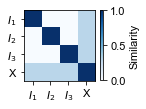

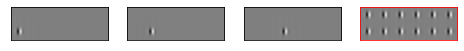

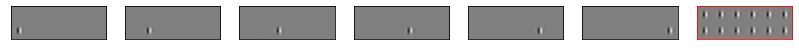

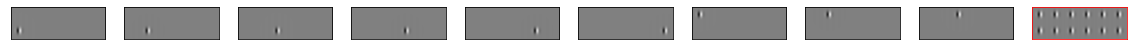

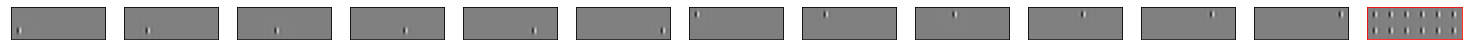

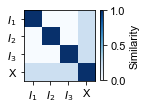

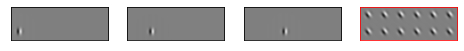

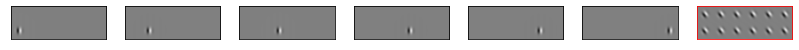

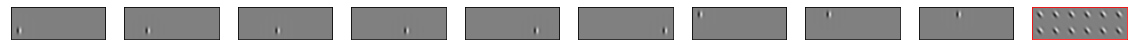

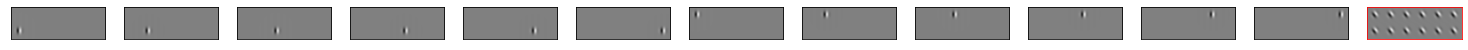

In [78]:
# Set paths
folder_name = '2024-11_exp-pred1_sum-of-parts'

path_data = path_data = f'/Users/sbecker/Projects/RL_reward_novelty/data/{folder_name}/'
sl.make_long_dir(path_data)

path_fig = f'/Users/sbecker/Projects/RL_reward_novelty/output/{folder_name}/'
sl.make_long_dir(path_fig)

# What to run
run_m  = True
run_l  = True
run_lp = True

# Rotation conditions to run
rotate      = np.array([0, 0.5, 0.509, 0.6, 1])*np.pi
color_list  = vis.prep_cmap('Blues',len(rotate))
rotate_plot = np.array([0,0.2])*np.pi
seed_parent = 12345

########################################################################################################################
# Run M-experiment
if run_m:

    name_data   = f'm_exp_seed-{seed_parent}_12base'
    name_fig    = name_data 

    plot_protocol(rotate_plot,unit_orient=0,seed_parent=seed_parent,save_path=path_fig,save_name=name_fig,exp_type='m')
    # run_perm(rotate,unit_orient=0,plot_stim=False,permute_all=False,seed_parent=seed_parent,save_stats=True,save_path=path_data,save_name=name_data,exp_type='m')

print('done')

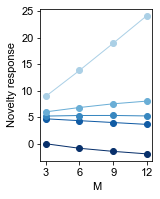

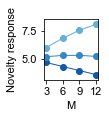

In [93]:
exp_type = 'm'
load_path = path_data
load_name = f'm_exp_seed-{seed_parent}_12base'
save_path = path_fig
save_name = load_name

field_vals   = 'n_fam' if exp_type=='l' else 'n_im' if exp_type=='m' else 'dN'
field_stats  = 'tr_norm_mean' if exp_type=='lp'  else 'nt_norm_mean'
field_stats2 = 'steady_mean' 

col_extract = col_extract = [field_vals,'tr_mean','tr_std','tr_sem','tr_norm_mean','tr_norm_std','tr_norm_sem','steady_mean','steady_std','steady_sem','sample_id','parent_id','perm_id','rotate','ksim'] if exp_type=='lp' else [field_vals,'nt_mean','nt_std','nt_sem','nt_norm_mean','nt_norm_std','nt_norm_sem','steady_mean','steady_std','steady_sem','sample_id','parent_id','perm_id','rotate','ksim']

sim_stats_raw = pd.read_csv(os.path.join(load_path,f'{load_name}.csv'),header=1,names=col_extract,index_col=False)
rotate = sim_stats_raw['rotate'].unique()
ksim = sim_stats_raw['ksim'].unique()

# rotate      = np.array([0, 0.5, 0.509, 0.6, 1])*np.pi
color_list  = vis.prep_cmap('Blues',len(rotate))

rotate1 = np.array([0,1,2,3,4])
rotate2 = np.array([1,2,3])

########################################################################################################################
f,ax = plt.subplots(1,1,figsize=(2,2.8))
for i in rotate1:
    stats_i = sim_stats_raw[np.round(sim_stats_raw['rotate'],6)==np.round(rotate[i],6)]
    nov_i_mean = stats_i[[field_vals,field_stats]].groupby([field_vals]).mean().reset_index()
    nov_i_std = stats_i[[field_vals,field_stats]].groupby([field_vals]).std().reset_index()

    rotsim_i = np.round(rotate[i]/np.pi,2)
    label_i = f'{int(np.round(rotsim_i))}$\pi$' if rotsim_i%1==0 else f'{rotsim_i}$\pi$'

    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'-',c=color_list[i])
    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'o',c=color_list[i],label=label_i)
    ax.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]-nov_i_std[field_stats],y2=nov_i_mean[field_stats]+nov_i_std[field_stats],color=color_list[i],alpha=0.2)

# ax.legend(loc='upper left',title='Rotation',frameon=False,handletextpad=0.1,bbox_to_anchor=(1,1))
ax.set_ylabel('Novelty response')
ax.set_xlabel('M')
ax.set_xticks([3,6,9,12])
# ax.set_ylim([-12,25])
# ax.legend(loc='lower left',frameon=False,handletextpad=0.05,bbox_to_anchor=(-0.1,-0.05),ncol=3,columnspacing=0.1)

# f.tight_layout()
f.savefig(os.path.join(save_path,f'{save_name}.svg'))
f.savefig(os.path.join(save_path,f'{save_name}.png'))   

########################################################################################################################
f,ax = plt.subplots(1,1,figsize=(1.5,1.6))
for i in rotate2:
    stats_i = sim_stats_raw[np.round(sim_stats_raw['rotate'],6)==np.round(rotate[i],6)]
    nov_i_mean = stats_i[[field_vals,field_stats]].groupby([field_vals]).mean().reset_index()
    nov_i_std = stats_i[[field_vals,field_stats]].groupby([field_vals]).std().reset_index()

    rotsim_i = np.round(rotate[i]/np.pi,2)
    label_i = f'{int(np.round(rotsim_i))}$\pi$' if rotsim_i%1==0 else f'{rotsim_i}$\pi$'

    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'-',c=color_list[i])
    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'o',c=color_list[i],label=label_i)
    ax.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]-nov_i_std[field_stats],y2=nov_i_mean[field_stats]+nov_i_std[field_stats],color=color_list[i],alpha=0.2)

# ax.legend(loc='upper left',frameon=False,handletextpad=0.1,bbox_to_anchor=(-0.025,1.01),ncol=3,columnspacing=0.2)
ax.set_ylabel('Novelty response')
ax.set_xlabel('M')
ax.set_xticks([3,6,9,12])
ax.set_ylim([3.2,8.5])

f.tight_layout()
f.savefig(os.path.join(save_path,f'{save_name}_zoom.svg'))
f.savefig(os.path.join(save_path,f'{save_name}_zoom.png'))   

## L-experiment

Sequence for rotation: 0.0
Sequence for rotation: 0.6283185307179586
Running realization 0 of L-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Running experiment condition 4 of experiment realization 0.

Done running experiments.

Done computing stats.



/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=dd

Running realization 0 of L-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Running experiment condition 4 of experiment realization 0.

Done running experiments.

Done computing stats.



/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=dd

Running realization 0 of L-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Running experiment condition 4 of experiment realization 0.

Done running experiments.

Done computing stats.



/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=dd

Running realization 0 of L-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Running experiment condition 4 of experiment realization 0.

Done running experiments.

Done computing stats.



/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=dd

Running realization 0 of L-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Running experiment condition 4 of experiment realization 0.

Done running experiments.

Done computing stats.

done


/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=dd

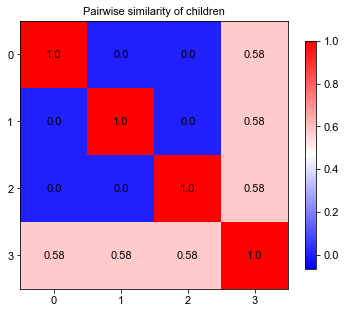

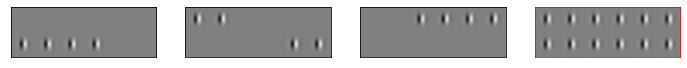

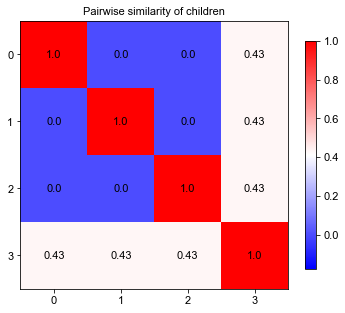

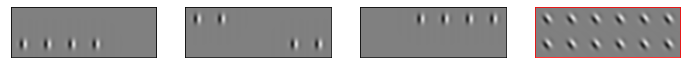

In [48]:
# Set paths
folder_name = '2024-11_exp-pred1_sum-of-parts'

path_data = path_data = f'/Users/sbecker/Projects/RL_reward_novelty/data/{folder_name}/'
sl.make_long_dir(path_data)

path_fig = f'/Users/sbecker/Projects/RL_reward_novelty/output/{folder_name}/'
sl.make_long_dir(path_fig)

# What to run
run_m  = True
run_l  = True
run_lp = True

# Rotation conditions to run
rotate      = np.array([0, 0.5, 0.509, 0.6, 1])*np.pi
color_list  = vis.prep_cmap('Blues',len(rotate))
rotate_plot = np.array([0,0.2])*np.pi
seed_parent = 12345

########################################################################################################################
# Run L-experiment
if run_l:

    name_data   = f'l_exp_seed-{seed_parent}_12base'
    name_fig    = name_data

    plot_protocol(rotate_plot,unit_orient=0,seed_parent=seed_parent,save_path=path_fig,save_name=name_fig,exp_type='l')
    run_perm(rotate,unit_orient=0,plot_stim=False,permute_all=False,seed_parent=seed_parent,save_stats=True,save_path=path_data,save_name=name_data,exp_type='l')
    # plot_perm(path_data,name_data,path_fig,name_fig,color_list,exp_type='l')

print('done')

[0.    0.5   0.509 0.6   1.   ]


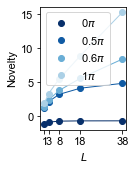

In [56]:
exp_type = 'l'
load_path = path_data
load_name = f'l_exp_seed-{seed_parent}_12base'
save_path = path_fig
save_name = load_name

field_vals   = 'n_fam'
field_stats  = 'nt_norm_mean'
field_stats2 = 'steady_mean' 

col_extract = [field_vals,'nt_mean','nt_std','nt_sem','nt_norm_mean','nt_norm_std','nt_norm_sem','steady_mean','steady_std','steady_sem','sample_id','parent_id','perm_id','rotate','ksim']

sim_stats_raw = pd.read_csv(os.path.join(load_path,f'{load_name}.csv'),header=1,names=col_extract,index_col=False)
rotate = sim_stats_raw['rotate'].unique()
print(rotate/np.pi)
ksim = sim_stats_raw['ksim'].unique()

# rotate      = np.array([0, 0.5, 0.509, 0.6, 1])*np.pi
color_list  = vis.prep_cmap('Blues',len(rotate))

rotate1 = [0,1,3,4]

f,ax = plt.subplots(1,1,figsize=(2,2.5))
for i in rotate1:
    stats_i = sim_stats_raw[sim_stats_raw['rotate']==rotate[i]]
    nov_i_mean = stats_i[[field_vals,field_stats]].groupby([field_vals]).mean().reset_index()
    nov_i_std = stats_i[[field_vals,field_stats]].groupby([field_vals]).std().reset_index()

    rotsim_i = np.round(rotate[i]/np.pi,2)
    label_i = f'{int(np.round(rotsim_i))}$\pi$' if rotsim_i%1==0 else f'{rotsim_i}$\pi$'

    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'-',c=color_list[i])
    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'o',c=color_list[i],label=label_i)
    ax.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]-nov_i_std[field_stats],y2=nov_i_mean[field_stats]+nov_i_std[field_stats],color=color_list[i],alpha=0.2)
        
ax.legend(loc='upper left')
ax.set_ylabel('Novelty')
ax.set_xlabel('$L$')
ax.set_xticks([1,3,8,18,38])

f.tight_layout()
f.savefig(os.path.join(save_path,f'{save_name}.svg'))
f.savefig(os.path.join(save_path,f'{save_name}.png'))   

## L'-experiment

Sequence for rotation: 0.0
Sequence for rotation: 0.6283185307179586
Running realization 0 of L'-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Running experiment condition 4 of experiment realization 0.

Running experiment condition 5 of experiment realization 0.

Running experiment condition 6 of experiment realization 0.

Done running experiments.

Done computing stats.

Running realization 0 of L'-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Running experiment condition 4 of experiment realization 0.

Running experiment condition 5 of experiment realization 0.

Runnin

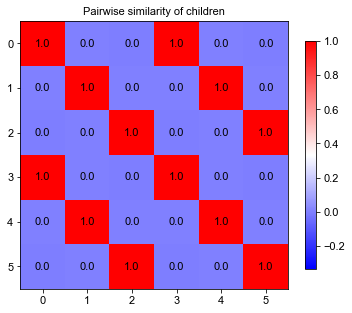

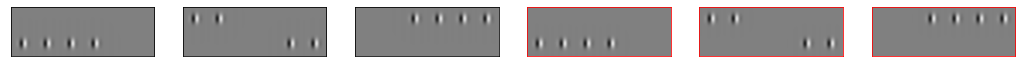

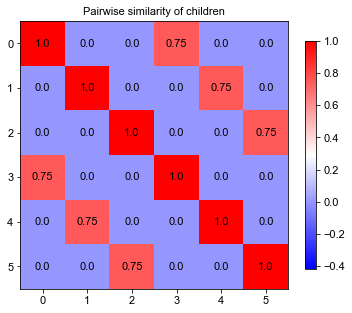

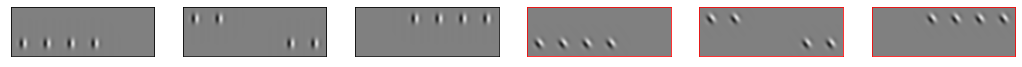

In [50]:
# Set paths
folder_name = '2024-11_exp-pred1_sum-of-parts'

path_data = path_data = f'/Users/sbecker/Projects/RL_reward_novelty/data/{folder_name}/'
sl.make_long_dir(path_data)

path_fig = f'/Users/sbecker/Projects/RL_reward_novelty/output/{folder_name}/'
sl.make_long_dir(path_fig)

# What to run
run_m  = True
run_l  = True
run_lp = True

# Rotation conditions to run
rotate      = np.array([0, 0.265, 0.27, 0.275, 0.28, 0.3, 0.6, 1])*np.pi
color_list  = vis.prep_cmap('Blues',len(rotate))
rotate_plot = np.array([0,0.2])*np.pi
seed_parent = 12345

########################################################################################################################
# Run L'-experiment
if run_lp:

    name_data   = f'lp_exp_seed-{seed_parent}_12base'
    name_fig    = name_data

    plot_protocol(rotate_plot,unit_orient=0,seed_parent=seed_parent,save_path=path_fig,save_name=name_fig,exp_type='lp')
    run_perm(rotate,unit_orient=0,plot_stim=False,permute_all=False,seed_parent=seed_parent,save_stats=True,save_path=path_data,save_name=name_data,exp_type='lp')    
    # plot_perm(path_data,name_data,path_fig,name_fig,color_list,exp_type='lp')

print('done')

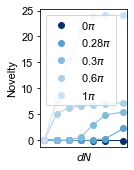

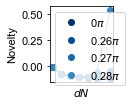

In [58]:
exp_type = 'lp'
load_path = path_data
load_name = f'lp_exp_seed-{seed_parent}_12base'
save_path = path_fig
save_name = load_name

field_vals   = 'dN'
field_stats  = 'tr_norm_mean'
field_stats2 = 'steady_mean' 

col_extract = col_extract = [field_vals,'tr_mean','tr_std','tr_sem','tr_norm_mean','tr_norm_std','tr_norm_sem','steady_mean','steady_std','steady_sem','sample_id','parent_id','perm_id','rotate','ksim']

sim_stats_raw = pd.read_csv(os.path.join(load_path,f'{load_name}.csv'),header=1,names=col_extract,index_col=False)
rotate = sim_stats_raw['rotate'].unique()
ksim = sim_stats_raw['ksim'].unique()

color_list  = vis.prep_cmap('Blues',len(rotate))

# [0, 0.265, 0.27, 0.275, 0.28, 0.3, 0.6, 1]
rotate1 = [0,4,5,6,7]
rotate2 = [0,1,2,3]

f,ax = plt.subplots(1,1,figsize=(2,2.5))
for i in rotate1:
    stats_i = sim_stats_raw[sim_stats_raw['rotate']==rotate[i]]
    nov_i_mean = stats_i[[field_vals,field_stats]].groupby([field_vals]).mean().reset_index()
    nov_i_std = stats_i[[field_vals,field_stats]].groupby([field_vals]).std().reset_index()

    rotsim_i = np.round(rotate[i]/np.pi,3)
    label_i = f'{int(np.round(rotsim_i))}$\pi$' if rotsim_i%1==0 else f'{rotsim_i}$\pi$'

    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'-',c=color_list[i])
    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'o',c=color_list[i],label=label_i)
    ax.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]-nov_i_std[field_stats],y2=nov_i_mean[field_stats]+nov_i_std[field_stats],color=color_list[i],alpha=0.2)

ax.legend(loc='upper left')
ax.set_ylabel('Novelty')
ax.set_xlabel('$dN$')
ax.set_xticks([])

f.tight_layout()
f.savefig(os.path.join(save_path,f'{save_name}.svg'))
f.savefig(os.path.join(save_path,f'{save_name}.png'))   

f,ax = plt.subplots(1,1,figsize=(1.8,1.6))
for i in rotate2:
    stats_i = sim_stats_raw[sim_stats_raw['rotate']==rotate[i]]
    nov_i_mean = stats_i[[field_vals,field_stats]].groupby([field_vals]).mean().reset_index()
    nov_i_std = stats_i[[field_vals,field_stats]].groupby([field_vals]).std().reset_index()

    rotsim_i = np.round(rotate[i]/np.pi,2)
    label_i = f'{int(np.round(rotsim_i))}$\pi$' if rotsim_i%1==0 else f'{rotsim_i}$\pi$'

    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'-',c=color_list[i])
    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'o',c=color_list[i],label=label_i)
    ax.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]-nov_i_std[field_stats],y2=nov_i_mean[field_stats]+nov_i_std[field_stats],color=color_list[i],alpha=0.2)

ax.legend(loc='upper left')
ax.set_ylabel('Novelty')
ax.set_xlabel('$dN$')
ax.set_xticks([])

f.tight_layout()
f.savefig(os.path.join(save_path,f'{save_name}_zoom.svg'))
f.savefig(os.path.join(save_path,f'{save_name}_zoom.png'))   

# f3,ax3 = plt.subplots(1,1,figsize=(3,3))
# for i in negative:
#     stats_i = sim_stats_raw[sim_stats_raw['rotate']==rotate[i]]
#     nov_i_mean = stats_i[[field_vals,field_stats]].groupby([field_vals]).mean().reset_index()
#     nov_i_std = stats_i[[field_vals,field_stats]].groupby([field_vals]).std().reset_index()

#     rotsim_i = 1-np.round(rotate[i]/np.pi,2)
#     label_i = f'{int(np.round(rotsim_i))}$\pi$' if rotsim_i%1==0 else f'{rotsim_i}$\pi$'

#     ax3.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'-',c=color_list[i])
#     ax3.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'o',c=color_list[i],label=label_i)
#     ax3.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]-nov_i_std[field_stats],y2=nov_i_mean[field_stats]+nov_i_std[field_stats],color=color_list[i],alpha=0.2)
        

# ax2.set_xlabel('$dN$')
# ax2.set_xticks([])
# ax2.set_ylabel('Novelty')
# f2.tight_layout()
# f2.savefig(os.path.join(save_path,f'{save_name}_scaled.svg'))
# f2.savefig(os.path.join(save_path,f'{save_name}_scaled.png'))  

# ax3.set_xlabel('$dN$')
# ax3.set_xticks([])
# ax3.set_ylabel('Novelty')
# f3.tight_layout()
# f3.savefig(os.path.join(save_path,f'{save_name}_zoom.svg'))
# f3.savefig(os.path.join(save_path,f'{save_name}_zoom.png'))  



# M-experiment (sum of parts) for random images

Sequence for rotation: 0.0
Sequence for rotation: 0.6283185307179586
Running realization 0 of M-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Done running experiments.

Done computing stats.



/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=dd

Running realization 0 of M-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Done running experiments.

Done computing stats.



/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=dd

Running realization 0 of M-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Done running experiments.

Done computing stats.



/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=dd

Running realization 0 of M-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Done running experiments.

Done computing stats.



/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=dd

Running realization 0 of M-experiment.

Running experiment condition 0 of experiment realization 0.

Running experiment condition 1 of experiment realization 0.

Running experiment condition 2 of experiment realization 0.

Running experiment condition 3 of experiment realization 0.

Done running experiments.

Done computing stats.

done


/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sbecker/opt/anaconda3/envs/rlnet/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=dd

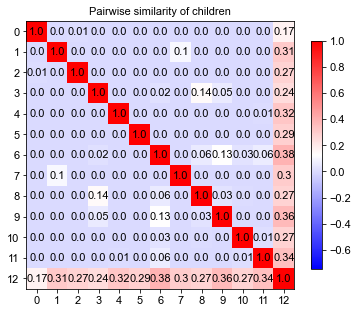

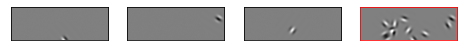

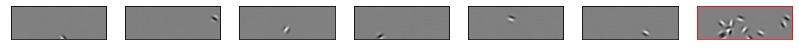

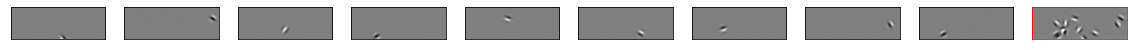

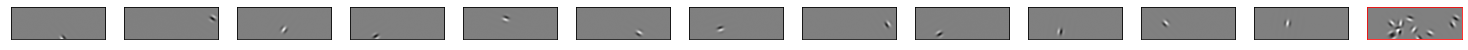

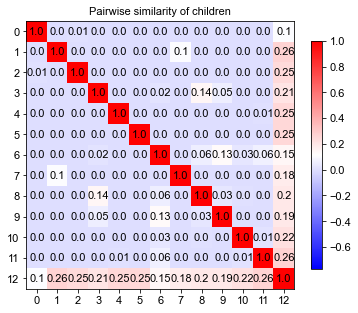

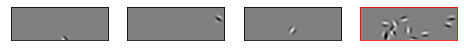

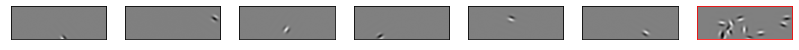

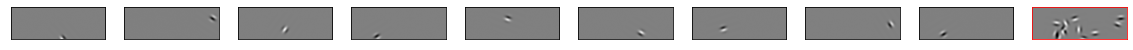

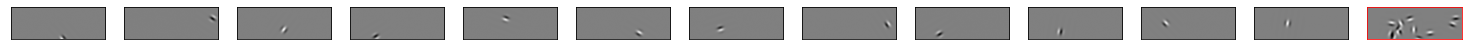

In [6]:
# Set paths
folder_name = '2024-11_exp-pred1_sum-of-parts_random-images'

path_data = path_data = f'/Users/sbecker/Projects/RL_reward_novelty/data/{folder_name}/'
sl.make_long_dir(path_data)

path_fig = f'/Users/sbecker/Projects/RL_reward_novelty/output/{folder_name}/'
sl.make_long_dir(path_fig)

# What to run
run_m  = True
run_l  = True
run_lp = True

# Rotation conditions to run
rotate      = np.array([0, 0.5, 0.509, 0.6, 1])*np.pi
color_list  = vis.prep_cmap('Blues',len(rotate))
rotate_plot = np.array([0,0.2])*np.pi
seed_parent = 12345

########################################################################################################################
# Run M-experiment
if run_m:

    name_data   = f'm_exp_seed-{seed_parent}_12base'
    name_fig    = name_data 

    plot_protocol(rotate_plot,unit_orient=0,seed_parent=seed_parent,save_path=path_fig,save_name=name_fig,exp_type='m',random_image=True)
    run_perm(rotate,unit_orient=0,plot_stim=False,permute_all=False,seed_parent=seed_parent,save_stats=True,save_path=path_data,save_name=name_data,exp_type='m',random_image=True)

print('done')

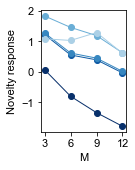

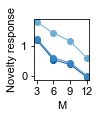

In [8]:
exp_type = 'm'
load_path = path_data
load_name = f'm_exp_seed-{seed_parent}_12base'
save_path = path_fig
save_name = load_name

field_vals   = 'n_fam' if exp_type=='l' else 'n_im' if exp_type=='m' else 'dN'
field_stats  = 'tr_norm_mean' if exp_type=='lp'  else 'nt_norm_mean'
field_stats2 = 'steady_mean' 

col_extract = col_extract = [field_vals,'tr_mean','tr_std','tr_sem','tr_norm_mean','tr_norm_std','tr_norm_sem','steady_mean','steady_std','steady_sem','sample_id','parent_id','perm_id','rotate','ksim'] if exp_type=='lp' else [field_vals,'nt_mean','nt_std','nt_sem','nt_norm_mean','nt_norm_std','nt_norm_sem','steady_mean','steady_std','steady_sem','sample_id','parent_id','perm_id','rotate','ksim']

sim_stats_raw = pd.read_csv(os.path.join(load_path,f'{load_name}.csv'),header=1,names=col_extract,index_col=False)
rotate = sim_stats_raw['rotate'].unique()
ksim = sim_stats_raw['ksim'].unique()

# rotate      = np.array([0, 0.5, 0.509, 0.6, 1])*np.pi
color_list  = vis.prep_cmap('Blues',len(rotate))

rotate1 = np.array([0,1,2,3,4])
rotate2 = np.array([1,2,3])

########################################################################################################################
f,ax = plt.subplots(1,1,figsize=(2,2.5))
for i in rotate1:
    stats_i = sim_stats_raw[np.round(sim_stats_raw['rotate'],6)==np.round(rotate[i],6)]
    nov_i_mean = stats_i[[field_vals,field_stats]].groupby([field_vals]).mean().reset_index()
    nov_i_std = stats_i[[field_vals,field_stats]].groupby([field_vals]).std().reset_index()

    rotsim_i = np.round(rotate[i]/np.pi,2)
    label_i = f'{int(np.round(rotsim_i))}$\pi$' if rotsim_i%1==0 else f'{rotsim_i}$\pi$'

    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'-',c=color_list[i])
    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'o',c=color_list[i],label=label_i)
    ax.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]-nov_i_std[field_stats],y2=nov_i_mean[field_stats]+nov_i_std[field_stats],color=color_list[i],alpha=0.2)

# ax.legend(loc='upper left',title='Rotation',frameon=False,handletextpad=0.1,bbox_to_anchor=(1,1))
ax.set_ylabel('Novelty response')
ax.set_xlabel('M')
ax.set_xticks([3,6,9,12])

f.tight_layout()
f.savefig(os.path.join(save_path,f'{save_name}.svg'))
f.savefig(os.path.join(save_path,f'{save_name}.png'))   

########################################################################################################################
f,ax = plt.subplots(1,1,figsize=(1.5,1.6))
for i in rotate2:
    stats_i = sim_stats_raw[np.round(sim_stats_raw['rotate'],6)==np.round(rotate[i],6)]
    nov_i_mean = stats_i[[field_vals,field_stats]].groupby([field_vals]).mean().reset_index()
    nov_i_std = stats_i[[field_vals,field_stats]].groupby([field_vals]).std().reset_index()

    rotsim_i = np.round(rotate[i]/np.pi,2)
    label_i = f'{int(np.round(rotsim_i))}$\pi$' if rotsim_i%1==0 else f'{rotsim_i}$\pi$'

    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'-',c=color_list[i])
    ax.plot(nov_i_mean[field_vals],nov_i_mean[field_stats],'o',c=color_list[i],label=label_i)
    ax.fill_between(x=nov_i_std[field_vals],y1=nov_i_mean[field_stats]-nov_i_std[field_stats],y2=nov_i_mean[field_stats]+nov_i_std[field_stats],color=color_list[i],alpha=0.2)

# ax.legend(loc='upper left',frameon=False,handletextpad=0.1,bbox_to_anchor=(-0.025,1.01),ncol=3,columnspacing=0.2)
ax.set_ylabel('Novelty response')
ax.set_xlabel('M')
ax.set_xticks([3,6,9,12])
# ax.set_ylim([3.2,8.5])

f.tight_layout()
f.savefig(os.path.join(save_path,f'{save_name}_zoom.svg'))
f.savefig(os.path.join(save_path,f'{save_name}_zoom.png'))   